# EDA e Analisi

In questo script importiamo i dati preparati nel preprocessing e da essi costruiamo dei modelli atti a prevedere le attività twitter nei vari comuni del Trentino in determinate fasce orarie.

### Librerie e funzioni

In [1]:
from pathlib  import Path

import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import Point

import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.metrics import mean_squared_error, recall_score, precision_score

In [2]:
def train_test(dataset, test_size=0.25):
    """
    Funzione che splitta i dati in train e test selezionando i dati per data.
    
    es.// test_size = 0.2 allora la funzione restituisce test formato da 12 giorni presi
          a caso e train con i restanti giorni
    """
    dates = dataset['date'].drop_duplicates().tolist() #elenco delle date nel formato giusto
    num_test = int(len(dates)*test_size) #numero di date nell'insieme di test dato test_size
    test_dates = np.random.choice(dates, num_test, replace=False) #sample delle date di test
    test = dataset[dataset['date'] == test_dates[0]] #inizializzo test
    #costruisco test
    for d in test_dates[1:]:
        test = test.append(dataset[twitter_weather['date'] == d])
    #costruisco train
    for p in test_dates:    
        dates.remove(p)
    train_dates = dates
    train = dataset[dataset['date'] == train_dates[0]] #inizializzo train
    for d in train_dates[1:]:
        train = train.append(dataset[dataset['date'] == d])

    return test,train

def perc(k,j):
    """
    Calcola le percentuali di tweet totali nelle le fasce scelte.
    """
    total_tweet = train[[f'fascia{i}' for i in range(0,24)]].sum().sum()
    perc = train[[f'fascia{i}' for i in range(k,j+1)]].sum().sum()/total_tweet*100
    return f'{round(perc,2)}%'

def raggruppa_fasce(dataset, n, intervalli):
    """
    Raggruppa le fascie da un'ora in n fascie.
    intervalli deve avere come primo elemento -1; i restanti elementi vanno messi
    secondo l'esempio sottostante.
    
    es: intervalli =  [-1, 3, 5, 23]
        raggruppa i tweet nelle fasce 00:00-03:59, 04:00-05:59, 6:00-23:59
    """
    for it in range(n):
        dataset[f'fascia_{intervalli[it]+1}{intervalli[it+1]}'] = dataset[[f'fascia{i}' for i in range(intervalli[it]+1, intervalli[it+1]+1)]].sum(axis=1)
        dataset.drop(columns = [f'fascia{i}' for i in range(intervalli[it]+1, intervalli[it+1]+1)], inplace = True)
        
def temperatures_precipitations_fasce(dataset,n,fasce):
    """
    Crea le fasce corrispettive a quelle dell'attività twitter
    con le temperature e le precipitazioni medie relative a ciascuna fascia.
    """
    #creo le liste HH e mm
    HH = [f'{i}' for i in range(24)]
    for i in range(24):
        if int(HH[i])<10:
            HH[i] = f'0{HH[i]}'
        else:
            HH[i] = f'{HH[i]}'
    mm = [f'{i}' for i in range(0,46,15)]
    mm[0] = '00'
    for it in range(n):
        dataset[f'temperatures_{fasce[it]+1}{fasce[it+1]}'] = dataset[[f'temperatures.{h}{m}' for h in HH[fasce[it]+1: fasce[it+1]+1] for m in mm]].mean(axis=1)
        dataset[f'precipitations_{fasce[it]+1}{fasce[it+1]}'] = dataset[[f'precipitations.{h}{m}' for h in HH[fasce[it]+1: fasce[it+1]+1] for m in mm]].mean(axis=1)
    dataset.drop(columns=[f'temperatures.{h}{m}' for h in HH for m in mm], inplace=True)
    dataset.drop(columns=[f'precipitations.{h}{m}' for h in HH for m in mm], inplace=True)
    
def drop_name(dataset, name_to_drop):
    """
    Rimuove i comuni in 'name_to_drop' dalla colonna 'name' del dataset.
    """
    dataset_with_index = dataset.set_index('name')
    dataset_with_index.drop(name_to_drop, inplace=True)
    dataset_with_index.reset_index(inplace=True)
    dataset = dataset_with_index
    dataset.sort_values(['date', 'name'], inplace=True)
    dataset.reset_index(inplace=True, drop=True)
    return dataset
    
def grafic_place(place, i,j):
    """
    Crea un barplot nella posizione [i][j] di un subplots
    relativo ai tweet totali per giorno di un comune
    (place è il dataset relativo a quel comune).
    """
    posto[f'{place}'].plot.bar(
        x='date_num', 
        y=fasce_string[1:], 
        stacked=True,  
        title=f'{place}', 
        #ylabel='# tweet',
        ax = axs[i][j],
        rot = 0,
        xlabel = ''
        )

def grafic_weather(weather,fascia, i,j):
    """
    Plot nella posizione [i][j] di un subplot. 
    Sull'asse x si hanno i dati meteo (temperatura o precipitazioni),
    sull'asse y il numero di tweet in una certa fascia.
    """
    train.plot(
        x=weather, 
        y=fascia,  
        #title=f'{weather} Vs #tweet', 
        #ylabel='# tweet',
        ax = axs[i][j],
        rot = 0,
        xlabel = '',
        style='o'
        )

def scaling(scaler, features, target):
    """
    Fa lo scaling del dataset train con lo scaler specificato e poi trasforma
    il dataset test di conseguenza.
    """
    features = features[:(len(features)-1)] #escludo la colonna weekend dallo scaling
    name = train['name'].drop_duplicates().tolist()
    #colonne nel dataset in uscita oltre a quelle riscalate
    final_features = ['date', 'name', 'weekend', 'date_num', 'name_num']+fasce_string
    scaler.fit(train[features].to_numpy())
    train_scaled = scaler.transform(train[features].to_numpy())
    test_scaled = scaler.transform(test[features].to_numpy())
    
    train_scaled = pd.DataFrame(train_scaled, columns=features)
    train_scaled = pd.concat((train_scaled, train[final_features]), 1) 
    test_scaled = pd.DataFrame(test_scaled, columns=features)
    test_scaled = pd.concat((test_scaled, test[final_features]), 1)
    return train_scaled, test_scaled

def categorize(dataset, treshold, oggetto):
    '''
    Categorizza le colonne oggetto_x in 0 se <= treshold e 1 altrimenti. 
    Ritorna un nuovo dataset con al posto delle colonne originali quelle categorizzate.
    '''
    a = dataset.copy()
    for k in range(len(fasce_string)):
        x = f'{fasce[k]+1}{fasce[k+1]}'
        a[f'{oggetto}_{x}']= a[f'{oggetto}_{x}'].apply(lambda x: x>=treshold).astype('int')
    return a

def RF( k, train, test,  param_grid, mod, CV='random'):
    """
    Regressione o classificazione (mod = 'class' or 'reg') con la RF 
    con fit su train. 
    CV ('manual' o 'random') indica se la CV
    è fatta tramite GridSearchCV o RandomizedSearchCV (sempre utilizzando param_grid
    come distribuzione di parametri).
    Inserisce i risultati come colonna nei dataset train e test col nome di 
    'predicted_x', con x che indica la fascia k-esima.
    Per la classificazione sono probabilità che quel determinato dato
    sia classificato come 1, per la regressione il valore previsto arrotondato.
    """
    x = f'{fasce[k]+1}{fasce[k+1]}' #stringa della fascia k-esima
    fascia_x = f'fascia_{x}'  #target
    features_x = [f'temperatures_{x}', f'precipitations_{x}', 'weekend', 'name_num'] #features
    if mod == 'reg':
        model = RandomForestRegressor()
    elif mod == 'class':
        model = RandomForestClassifier()
    if CV == 'manual':
        CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
    elif CV == 'random':  
        CV = RandomizedSearchCV(estimator = model, param_distributions = param_grid,
                   n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
    CV.fit(train[features_x], train[fascia_x])
    best_param = CV.best_params_
    if mod == 'reg':
        best_model = RandomForestRegressor(
        n_estimators=best_param['n_estimators'],
        min_samples_split=best_param['min_samples_split'],
        min_samples_leaf = best_param['min_samples_leaf'],
        bootstrap = best_param['bootstrap'],
        max_depth=best_param['max_depth'],
        max_features=best_param['max_features']
                                      )
    elif mod == 'class':
        best_model = RandomForestClassifier(
        n_estimators=best_param['n_estimators'],
        min_samples_split=best_param['min_samples_split'],
        min_samples_leaf = best_param['min_samples_leaf'],
        bootstrap = best_param['bootstrap'],
        max_depth=best_param['max_depth'],
        max_features=best_param['max_features']
                                      )
    best_model.fit(train[features_x], train[fascia_x])
    if mod == 'reg':
        train[f'predicted_{x}'] = best_model.predict(train[features_x])
        test[f'predicted_{x}'] = best_model.predict(test[features_x])
        #arrotondo valori (tweet sono interi) per la regressione
        train[f'predicted_{x}'] = train[f'predicted_{x}'].apply(lambda x: round(x))
        test[f'predicted_{x}'] = test[f'predicted_{x}'].apply(lambda x: round(x))
    elif mod == 'class':
        #inserisco colonna probabilità (selezione colonna con le probabilità di classificare 1)
        train[f'probability_{x}'] = best_model.predict_proba(train[features_x])[:,1]
        test[f'probability_{x}'] = best_model.predict_proba(test[features_x])[:,1]
    return best_param

def prec_rec(train, beta=0.5):
    """
    Plotta le precision-recall curve di train e ritorna le migliori thresholds 
    per ogni fascia secondo il Fbeta-score.
    """
    best_thresholds = []
    for k in range(1,len(fasce_string)):
        x = f'{fasce[k]+1}{fasce[k+1]}'
        #precision recall
        precision, recall, thresholds = precision_recall_curve(train[f'fascia_{x}'], train[f'probability_{x}'])
        # convert to f score
        fbscore = ((1+beta**2)* precision * recall) / ((beta**2)*precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fbscore)
        best_thresholds += [thresholds[ix]]
        print(f'Best Threshold=%f, F{beta}-Score=%.3f' % (thresholds[ix], fbscore[ix]))
        plt.plot( recall, precision, label=f'RFC_{x}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.scatter(recall[ix], precision[ix], marker='o', color='black', label=f'Best_{x}')
        plt.legend()
        plt.title('Precision-Recall')
    return best_thresholds
    
def plot_cm(true, predicted, num_raws, num_columns, figsize = (10,7) ):
    """
    Plot delle confusion matrix per ogni fascia.
    True è il dataset dal quale i dati veri vengono presi, mentre
    predicted quello dal quale vengono presi i dati predetti.
    num_raws e num_columns indicano il numero di righe e di colonne 
    rispettivamente del subplot.
    """
    fig, axs= plt.subplots(num_raws, num_columns, figsize=figsize, squeeze=False)
    for i in range(num_raws):
        for j in range(num_columns):
            if i == 0:
                k = j+1
            else:
                k = 2+j+i
            x = f'{fasce[k]+1}{fasce[k+1]}'
            cm = confusion_matrix(true[f'fascia_{x}'], predicted[f'predicted_{x}'])
            sns.heatmap(cm, annot = True, ax = axs[i][j])
            axs[i][j].set_title(f'Fascia_{x}')
            axs[i][j].set_xlabel('Predicted')
            axs[i][j].set_ylabel('True')

def report_score(score, score_string, train, test):
    """
    Stampa gli score di train e di test per ogni fascia una volta fatta la classificazione.
    """
    for k in range(1,len(fasce_string)):
        x = f'{fasce[k]+1}{fasce[k+1]}'
        print(f'{score_string}_in fascia_{x} = %.2f' % score(train[f'fascia_{x}'], train[f'predicted_{x}']))
        print(f'{score_string}_out fascia_{x} = %.2f' % score(test[f'fascia_{x}'], test[f'predicted_{x}']))
            
def plot_total_tweet(dataset,num_raws = 1, num_columns = 3, figsize=(15,10)):
    fig, axs= plt.subplots(num_raws, num_columns, figsize=figsize, squeeze=False)
    for i in range(num_raws):
        for j in range(num_columns):
            dataset.groupby('name').sum()[fasce_string[1+j+i*2]].plot.bar(
                                                                        ax = axs[i][j], 
                                                                        legend=True
                                                                             )
            dataset.groupby('name').sum()[f'predicted_{fasce[1+j+i*2]+1}{fasce[1+j+i*2+1]}'].plot.bar(
                                                                                                color = 'red', 
                                                                                                alpha=0.5,ax = axs[i][j], 
                                                                                                legend = True
            )
                    

### Importo dati ripuliti (e altri dataset per i grafici in EDA)

Importiamo i dati ripuliti 'twitter_weather' su cui lavoreremo e i dataset 'grid', 'weather', 'twitter' utili per l'EDA.

In [3]:
data_path = Path('./data/raw')

files = {'grid':'trentino-grid.geojson',
        'weather':'meteotrentino-weather-station-data.json',
        'twitter':'social-pulse-trentino.geojson'}

In [4]:
grid = gpd.read_file(data_path / files['grid'])
with open(data_path / files['weather']) as f:
    weather_json = json.load(f)
weather = gpd.GeoDataFrame(weather_json['features'])
with open(data_path / files['twitter']) as f:
    twitter_json = json.load(f)
twitter = gpd.GeoDataFrame(twitter_json['features'])
twitter_weather = pd.read_csv('./data/processed/twitter_weather.csv')

In [5]:
#inserisco colonna geometry per i plot
twitter['geometry'] = twitter['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
twitter.drop(columns=['geomPoint.geom'],inplace=True)
weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'],inplace=True)

### Train/Test

Suddividiamo twitter_weather in un insieme di train e in uno di test.  
L'insieme di test conterrà il 20% dei dati totali.  
NB! I due insiemi vengono suddivisi in base alla data, ovvero l'insieme di train verrà costruito prendendo a caso 49 giorni dal dataset originale e quello di test prendendo i restanti 12.

In [6]:
test_size = 0.2

In [7]:
#Definisco test e train
test,train = train_test(twitter_weather, test_size=test_size)
train = train.sort_values('date')
test = test.sort_values('date')

#numero giorni train e test
num_gg_train = train.groupby('date').count().shape[0]
num_gg_test = test.groupby('date').count().shape[0]
total_train_tweet = round(train[[f'fascia{i}' for i in range(24)]].sum().sum())
print(f'# giorni train: {num_gg_train}')
print(f'# giorni test: {num_gg_test}')
print(f'# tweet train: {total_train_tweet}')

# giorni train: 49
# giorni test: 12
# tweet train: 21322


Da questo momento tutte le analisi e considerazioni verranno fatte usando l'insieme di train;
l'insieme di test verrà usato successivamente per valutare l'efficacia dei modelli.

### EDA

#### Fasce orarie

Definisco le fasce orarie in cui raggruppare l'attività twitter, per ogni data e per ogni comune, che andranno a costituire i nostri target.

Plotto il numero di tweet totali orari su tutto il periodo considerato e su tutti i comuni per andare a selezionare delle fasce efficaci sui cui concentrare l'analisi.

<AxesSubplot:title={'center':'Fasce orarie VS tweet totali (per ogni giorno e per ogni luogo)'}, ylabel='# tweet'>

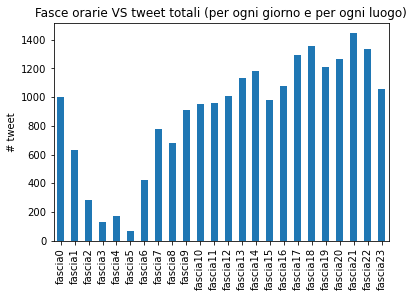

In [8]:
train[[f'fascia{i}' for i in range(0,24)]].sum().plot.bar(title = 'Fasce orarie VS tweet totali (per ogni giorno e per ogni luogo)', ylabel='# tweet')

In [9]:
print(f'Dalle 10:00 alle 23:59 ho il {perc(10,23)} dei dati totali; divido in 3 fasce successive alle 10:00 in modo tale che queste siano circa equilibrate.')
print(f'00:00-09:59 ({perc(0,9)}); 10:00-14:59 ({perc(10,14)}); 15:00-19:59 ({perc(15,19)}); 20:00-23:59 ({perc(20,23)})')

Dalle 10:00 alle 23:59 ho il 76.24% dei dati totali; divido in 3 fasce successive alle 10:00 in modo tale che queste siano circa equilibrate.
00:00-09:59 (23.76%); 10:00-14:59 (24.54%); 15:00-19:59 (27.75%); 20:00-23:59 (23.94%)


Vediamo quindi che le fasce rilevanti sono: 10:00-14:59, 15:00-19:59 e 20:00-23:59.  
Raggruppo i tweet in queste fasce, sia in train che in test.

In [10]:
fasce = [-1, 9, 14, 19, 23]   
#numero di fasce
n = len(fasce)-1 
#lista delle fasce orarie
fasce_string = [f'fascia_{fasce[i]+1}{fasce[i+1]}' for i in range(n)] 

raggruppa_fasce(train,n, fasce)
raggruppa_fasce(test,n, fasce)

Ai fini dell'analisi raggruppiamo nelle medesime fasce i dati meteo (temperature e precipitazioni) prendendo il valore medio per ciascuna fascia.

In [11]:
temperatures_precipitations_fasce(train,n,fasce)
temperatures_precipitations_fasce(test,n,fasce)
train.head()

,date,name,elevation,date_num,weekend,fascia_09,fascia_1014,fascia_1519,fascia_2023,temperatures_09,precipitations_09,temperatures_1014,precipitations_1014,temperatures_1519,precipitations_1519,temperatures_2023,precipitations_2023
0,2013-11-01,Ala,170,1,0,0.0,0.0,0.0,0.0,10.9100,0.0,16.995,0.0,14.915,0.0,12.21875,0.0000
20,2013-11-01,Pergine Valsugana,458,1,0,0.0,1.0,2.0,2.0,10.9450,0.0,14.630,0.0,13.575,0.0,10.96875,0.0000
21,2013-11-01,Pieve di Bono,525,1,0,0.0,0.0,0.0,0.0,9.4375,0.0,13.015,0.0,13.145,0.0,12.01875,0.0000
22,2013-11-01,Pinzolo,760,1,0,0.0,0.0,0.0,2.0,10.0400,0.0,13.425,0.0,11.705,0.0,10.35625,0.0125
23,2013-11-01,Predazzo,1000,1,0,0.0,0.0,1.0,2.0,8.5375,0.0,12.725,0.0,10.170,0.0,8.18125,0.0000


#### Grafici

Visualizziamo graficamente il comportamento dei dati.

Creo la lista dei nomi dei comuni (con colonnina) in ordine alfabetico.

In [12]:
#Lista dei comuni con colonnina
name = train['name'].drop_duplicates().tolist()
name.sort()

* Plot della mappa del Trentino con colonnine meteo e posizione di ciascun tweet

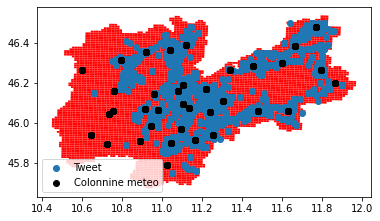

In [13]:
ax = grid.plot(color = 'red')
twitter.plot(ax=ax, label = 'Tweet')
weather.plot( ax=ax, color = 'black', label='Colonnine meteo')
plt.legend()

Dal grafico si vede che ci sono almeno 3 colonnine senza tweet nelle vicinanze (nella zona a sinistra).

* Heatmap delle correlazioni Pearson 

<AxesSubplot:>

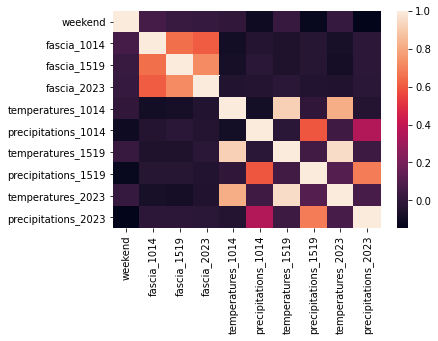

In [14]:
corr = train[train.columns.drop(['elevation', 'date_num', 'fascia_09', 'temperatures_09', 'precipitations_09'])].corr()
sns.heatmap(corr)

Dal grafico si vede che non ci sono correlazioni (lineari) rilevanti se non tra features simili. Con simili si intende le stesse features ma in fasce orarie differenti, come ad esempio 'temperatures_1519' e 'temperatures_2023'.

* Plot dei tweet totali per comune

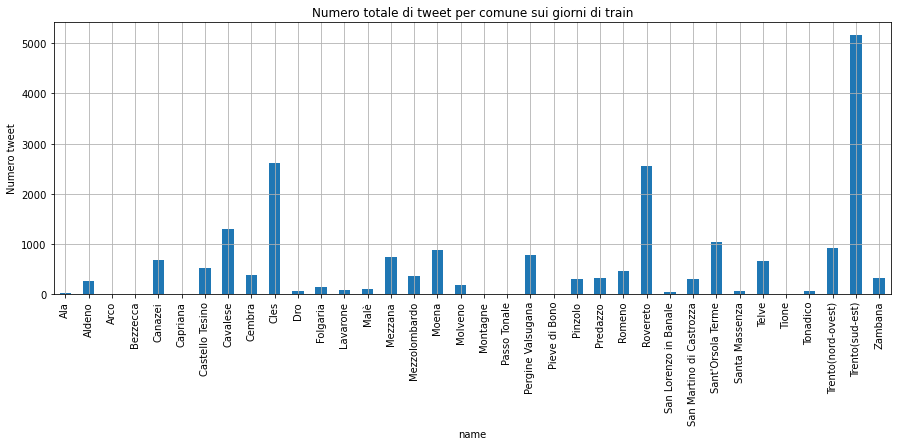

In [15]:
plt.figure(figsize=(15,5))
train.groupby('name').sum()[fasce_string].sum(axis=1).plot.bar(ylabel = f'Numero tweet', title = 'Numero totale di tweet per comune sui giorni di train')
plt.grid()

Si vede chiaramente dal grafico che le 3 zone più attive (sull'intero periodo di train) sono Cles, Rovereto e Trento(sud-est).   
Ci sono inoltre zone quasi del tutto inattive, ovvero: Ala, Arco, Bezzecca, Montagne, Passo Tonale, Pieve di Bono, Tione. 

In [16]:
name_scartare = ['Ala', 'Arco', 'Bezzecca', 'Capriana', 'Montagne', 'Passo Tonale', 'Pieve di Bono', 'Tione']

b = 0
for i in range(0,len(name_scartare)):
    b += train[train['name'] == name_scartare[i]][fasce_string].sum().sum()
print(f'In {name_scartare} ho lo {round(b/total_train_tweet*100,2)}% dei tweet totali.')

In ['Ala', 'Arco', 'Bezzecca', 'Capriana', 'Montagne', 'Passo Tonale', 'Pieve di Bono', 'Tione'] ho lo 0.1% dei tweet totali.


Rimuovo quindi questi comuni dal dataset, dato che il nostro obbiettivo è quello di individuare i comuni più attivi.

In [17]:
train = drop_name(train, name_scartare)
test = drop_name(test, name_scartare)
#ridefinisco la lista dei comuni
name = train['name'].drop_duplicates().tolist()

* Trend geografici: barplot dei tweet totali per giorno suddivisi nella fasce orarie per ogni comune

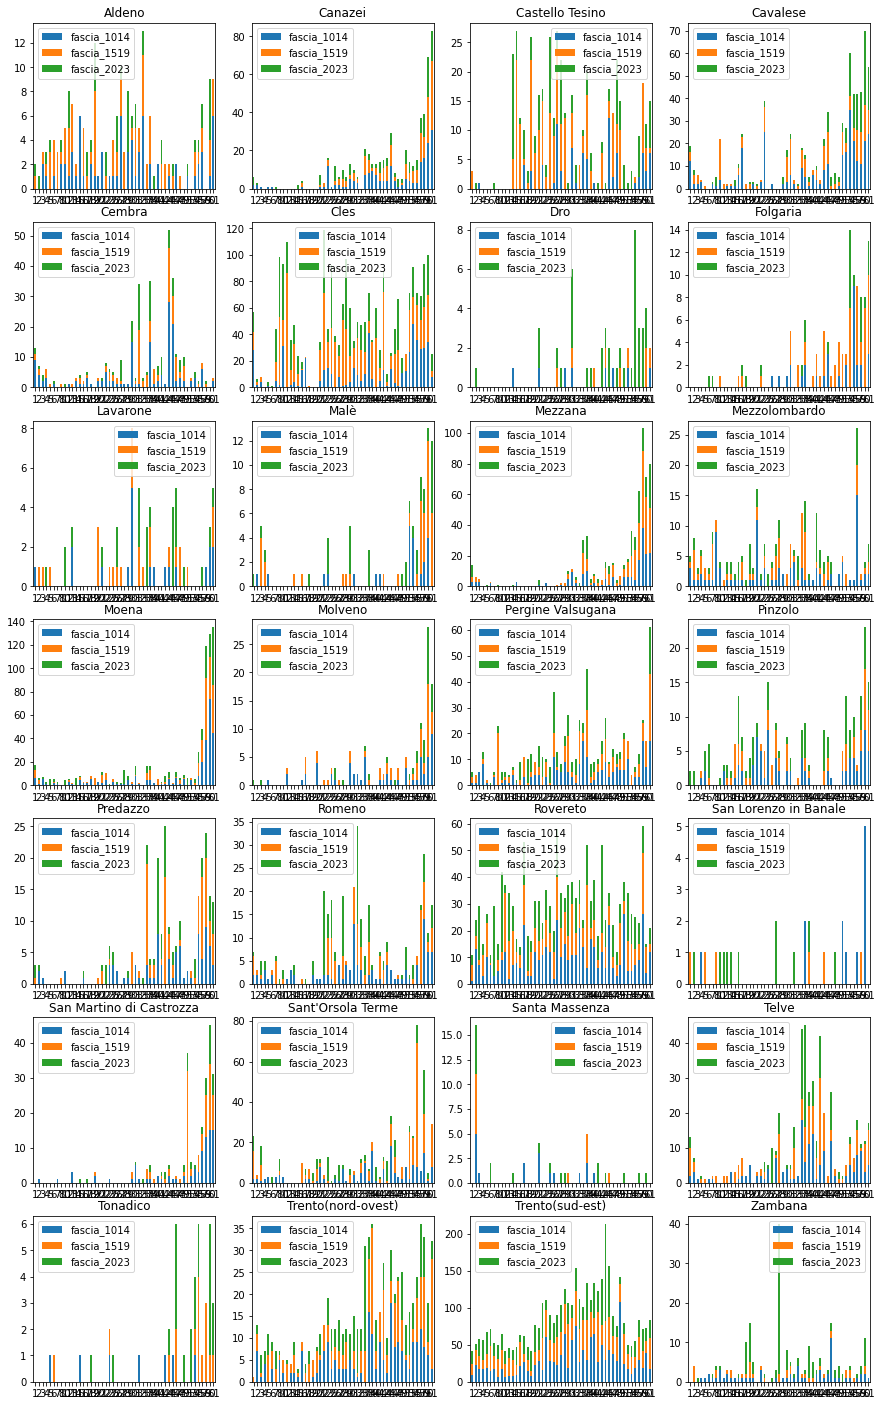

In [18]:
#dizionario che estrae data per luogo
posto = {}
for i in range(len(name)):
    posto[name[i]] = train[train['name'] == name[i]]

fig, axs= plt.subplots(int(len(name)/4),4, figsize=(15,25))

for i in range(int(len(name)/4)):
    for j in range(4):
        grafic_place(name[i*4+j], i, j)

Si vede come nelle zone densamente popolate l'attività twitter sia più distribuita rispetto alla data (ad esempio a Rovereto e Trento), mentre nelle località meno popolate e turistiche l'attività cresca all'aumentare della data (ad esempio a Tonadico e Canazei).   
Questo comportamento potrebbe essere spiegato dall'avvicinarsi delle festività natalizie con l'aumentare dei giorni con un conseguente aumento di turisti in queste località; questa però è una nostra supposizione in quanto per studiare effettivamente l'andamento dell'attività in funzione del giorno specifico avremmo bisogno di anni di dati, mentre noi abbiamo a disposizione solamente 2 mesi.  
Questa osservazione è quindi ininfluente per quanto riguarda i nostri scopi ma ci sembrava interessante da far notare.

* Weekend/non weekend

In [19]:
percentuale_weekend = train[train['weekend'] == 1][fasce_string].sum().sum()/train[fasce_string].sum().sum()
print(f'Il {round(percentuale_weekend*100,2)}% dei tweet avviene nei weekend.')

Il 31.16% dei tweet avviene nei weekend.


I giorni di weekend sono circa i 2/7 dei giorni totali, quindi sembrerebbe esserci una leggera maggiore attività nei weekend.

* Correlazione dati meteo

Plot dei dati meteo e numero di tweet in una determinata fascia.  
Nella prima riga sono riportate sull'asse x le temperature in °C mentre nella seconda le precipitazioni in mm. Sugli assi y sono riportati il numero di tweet in una determinata fascia oraria specificata nella legenda.

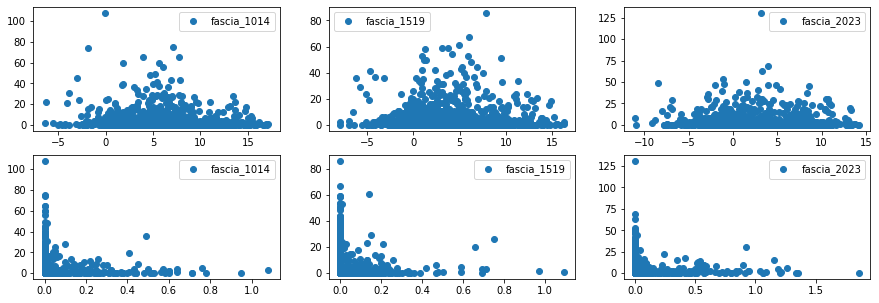

In [20]:
fig, axs= plt.subplots(2,3, figsize=(15,5))

for i in range(2):
    for j in range(3):
        if i == 0: #prima riga metto temperatures
            grafic_weather(f'temperatures_{fasce[j+1]+1}{fasce[j+2]}',fasce_string[j+1], i, j)
        else:
            grafic_weather(f'precipitations_{fasce[j+1]+1}{fasce[j+2]}',fasce_string[j+1], i, j)

Qualitivamente si osserva che per quanto riguarda la temperatura il numero massimo di tweet si ha nell'intorno della temperatura media corrispondente alla fascia considerata, mentre per le precipitazioni in tutte le fasce abbiamo il picco di tweet quando non piove e diminuiscono quando la pioggia aumenta di intensità. 

### Modelli

In questa sezione ci occupiamo dello sviluppo e del testing di due modelli.  
  
Il primo modello ha l'obbiettivo di classificare, in un dato giorno e nelle varie fasce orarie, quali sono i comuni con maggiore attività twitter in relazione ai dati meteo e se quel giorno è un weekend o meno.  
  
Il secondo modello è una regressione che ha lo scopo di prevedere l'attività twitter per ogni comune, sulla base degli stessi dati del primo, in un dato giorno per le varie fasce orarie.    

Per entrambi i modelli sono state usate le random forests capaci di cogliere relazioni non lineari.

Assegno un valore numerico ad ogni comune da 0 a N dove N è il numero di comuni considerato (in ordine crescente secondo l'ordine alfabetico dei nomi dei comuni) e inserisco questi valori nella colonna 'name_num' nei dataset di train e test.

In [21]:
number = LabelEncoder()
train['name_num'] = number.fit_transform(train['name'])
test['name_num'] = number.fit_transform(test['name'])

#### Rescaling

Riscalo i dati con StandardScaler per avere delle distribuzioni di features con valori confrontabili.

In [22]:
features = [f'precipitations_{fasce[i]+1}{fasce[i+1]}' for i in range(n)] + [f'temperatures_{fasce[i]+1}{fasce[i+1]}' for i in range(n)]+['weekend']
target = [f'fascia_{fasce[i]+1}{fasce[i+1]}' for i in range(1,n)] #escludo prima fascia
#Riscalo train e poi test
scaler = StandardScaler() 
train_rescale, test_rescale = scaling(scaler, features, target)

#### Classificazione

Imposto una threshold per categorizzare l'attività twitter.  
Se in un comune, in una fascia oraria, il numero di tweet è maggiore o uguale a questa threshold allora il comune è classificato come attivo (classe 1), altrimenti come inattivo (classe 0).

In [23]:
treshold = 10

train_class = categorize(train_rescale, treshold, 'fascia')
test_class = categorize(test_rescale, treshold, 'fascia')

I parametri del modello (RandomForestClassifier) vengo scelti in base ad una cross validation 5-fold. Vengono scelte 100 combinazioni di parametri da param_grid e per ognuna di queste vengono quindi fatti 5 fit.  
Abbiamo scelto di usare RandomizedSearchCV perchè i tempi di calcolo con GridSearchCV usando lo stesso numero di parametri è troppo lungo e ridurre il numero di parametri in param_grid significherebbe esplorare meno possibilità e quindi ottenere un modello limitato.

In [24]:
param_grid = {
'n_estimators': [5,20,50,100,200,500],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
'min_samples_split': [int(x) for x in np.linspace(2, 10, num=9)],
'min_samples_leaf': [int(x) for x in np.linspace(2, 10, num=9)],
'bootstrap': [True, False]
}

In [25]:
best_param_class = []
for k in range(1,len(fasce_string)):
    best_param_class += [RF(k,train_class, test_class,param_grid, 'class')]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Da questi fit otteniamo delle probabilità di assegnare una riga del dataset alla classe 1 (comune attivo).  
Inseriamo queste probabilità sotto le colonne probability_x (con x che indica la fascia) nei dataset train_class e test_class.

In [26]:
train_class.head()

,precipitations_09,precipitations_1014,precipitations_1519,precipitations_2023,temperatures_09,temperatures_1014,temperatures_1519,temperatures_2023,date,name,weekend,date_num,name_num,fascia_09,fascia_1014,fascia_1519,fascia_2023,probability_1014,probability_1519,probability_2023
0,-0.35329,-0.278951,-0.291644,-0.263778,2.127991,2.613688,2.749529,2.549239,2013-11-01,Aldeno,0,1,0,0,0,0,0,0.019390,0.048277,0.084959
1,-0.35329,-0.278951,-0.291644,-0.263778,0.744448,0.815812,0.781879,0.855041,2013-11-01,Canazei,0,1,1,0,0,0,0,0.000980,0.017435,0.015910
2,-0.35329,-0.278951,-0.291644,-0.263778,1.594611,1.294010,1.416725,1.236344,2013-11-01,Castello Tesino,0,1,2,0,0,0,0,0.017211,0.073099,0.011802
3,-0.35329,-0.278951,-0.291644,-0.263778,1.394243,1.422518,1.462513,1.452993,2013-11-01,Cavalese,0,1,3,0,1,0,0,0.063469,0.068186,0.023959
4,-0.35329,-0.278951,-0.291644,-0.263778,1.714943,1.817927,1.875843,1.906512,2013-11-01,Cembra,0,1,4,0,0,0,0,0.047084,0.110579,0.092463


Ci aspettiamo che i comuni attivi siano minori di quelli inattivi, ovvero ci aspettiamo delle **classi sbilanciate**, e per il nostro scopo ci interessa individuare con la maggiore precisione ottenibile un numero più alto possibile di positivi (inteso come classe 1, ovvero comune attivo).   
Si va quindi a studiare la precision-recall curve.    
In un'ottica aziendale si è deciso di minimizzare i rischi limitando il più possibile i falsi positivi, infatti il costo di un falso positivo per un'eventuale azienda (investo ma non guadagno) è più alto di un falso negativo (non investo e non guadagno) immaginando di dover indirizzare una campagna pubblicitaria.  
Cerchiamo quindi di massimizzare la precision e allo stesso tempo di avere una recall accettabile.  
Uso quindi il F_0.5-score per selezionare la threshold (infatti questo score mette più enfasi sulla precision, fonte: https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_data).         
Ragionamento: meno pubblicità ma più efficaci.

Best Threshold=0.313368, F0.5-Score=0.732
Best Threshold=0.356020, F0.5-Score=0.769
Best Threshold=0.378856, F0.5-Score=0.757


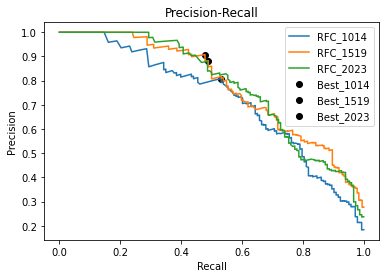

In [27]:
best_thresholds = prec_rec(train_class, beta = 0.5)

Una volta impostata la threshold creo le colonne con le classificazioni predette, una per ogni fascia.   
Le chiamo 'predicted_x' con x che indica la fascia.

In [28]:
for k in range(1,len(fasce_string)):
    x = f'{fasce[k]+1}{fasce[k+1]}'
    train_class[f'predicted_{x}'] = (train_class[f'probability_{x}'] >= best_thresholds[k-1]).astype('int')
    test_class[f'predicted_{x}'] = (test_class[f'probability_{x}'] >= best_thresholds[k-1]).astype('int')

* Confusion matrix    

Dati di train 

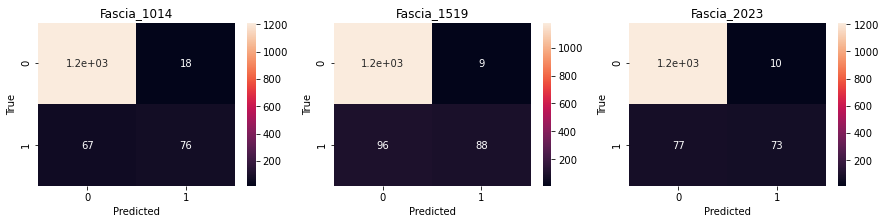

In [29]:
num_raws = 1
num_columns = round(len(fasce_string)-1)
true = train_class
predicted = train_class
plot_cm(true, predicted, num_raws, num_columns, figsize=(15,3))

Vadiamo che così facendo otteniamo sì un alto numero di falsi negativi ma in compenso otteniamo un basso numero di falsi positivi che, come spiegato prima, era il nostro scopo.

Plottiamo le confusion matrix anche per l'insieme di test per vedere se il modello generalizza effettivamente questo comportamento.  
Riportiamo inoltre gli score (precision e recall) su train (in) e su test (out).

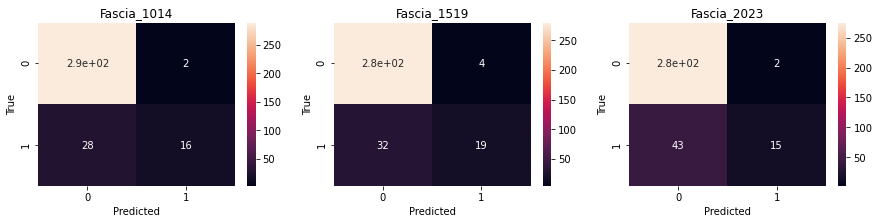

In [30]:
true = test_class
predicted = test_class
plot_cm(true, predicted, num_raws, num_columns, figsize=(15,3))

In [31]:
report_score(precision_score, 'Precision', train_class, test_class)

Precision_in fascia_1014 = 0.81
Precision_out fascia_1014 = 0.89
Precision_in fascia_1519 = 0.91
Precision_out fascia_1519 = 0.83
Precision_in fascia_2023 = 0.88
Precision_out fascia_2023 = 0.88


In [32]:
report_score(recall_score, 'Recall', train_class, test_class)

Recall_in fascia_1014 = 0.53
Recall_out fascia_1014 = 0.36
Recall_in fascia_1519 = 0.48
Recall_out fascia_1519 = 0.37
Recall_in fascia_2023 = 0.49
Recall_out fascia_2023 = 0.26


Dagli score vediamo che la precision rimane sufficientemente alta, come voluto, anche al di fuori dell'insieme di training.  
Per quanto riguarda invece la recall, vediamo che si abbassa uscendo dall'insieme di train, il che è indice di un leggero overfitting.  
Questo overfitting si vede dalle accuracy (riportate di sotto), che sono leggermente più basse fuori dal train.

In [33]:
report_score(accuracy_score, 'Accuracy', train_class, test_class)

Accuracy_in fascia_1014 = 0.94
Accuracy_out fascia_1014 = 0.91
Accuracy_in fascia_1519 = 0.92
Accuracy_out fascia_1519 = 0.89
Accuracy_in fascia_2023 = 0.94
Accuracy_out fascia_2023 = 0.87


Questo è dovuto al numero ridotto dei dati; è possibile ridurre questo overfitting aumentando ad esempio il numero di giorni presi in esame.

#### Regressione

Le modalità per il fit sono analoghe a quelle usate per la classificazione.

In [34]:
param_grid = {
'n_estimators': [5,20,50,100,200,500],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
'min_samples_split': [int(x) for x in np.linspace(2, 10, num=9)],
'min_samples_leaf': [int(x) for x in np.linspace(2, 10, num=9)],
'bootstrap': [True, False]
}

In [35]:
best_param_reg = []
for k in range(1,len(fasce_string)):
    best_param_reg += [RF(k,train_rescale, test_rescale,param_grid, 'reg')]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


* Plot dei tweet totali per comune per ogni fascia oraria.

Train

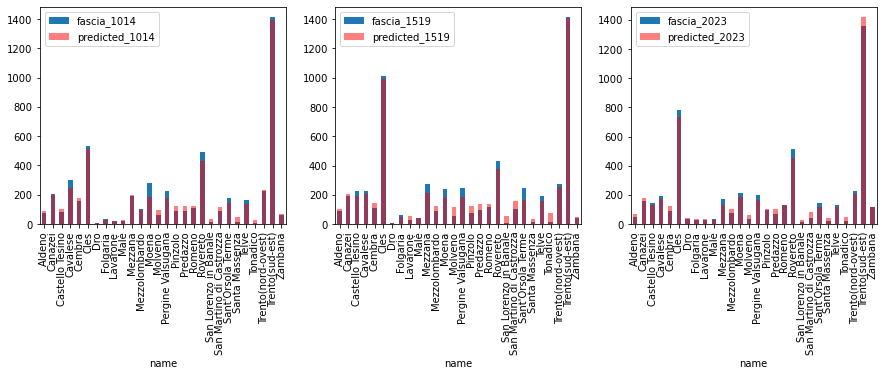

In [36]:
plot_total_tweet(train_rescale, figsize=(15,4))

Test

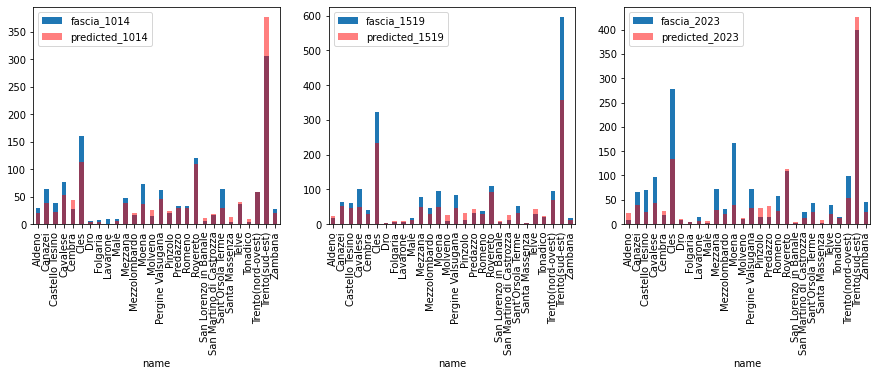

In [37]:
plot_total_tweet(test_rescale, figsize=(15,4))

Già da questi grafici si osserva che il modello fa un overfit sui dati.   
Riportiamo gli scarti quadratici medi di train e di test per mettere in evidenza questa osservazione.

In [38]:
report_score(mean_squared_error, 'E', train_rescale, test_rescale)

E_in fascia_1014 = 30.92
E_out fascia_1014 = 28.77
E_in fascia_1519 = 33.75
E_out fascia_1519 = 137.30
E_in fascia_2023 = 26.74
E_out fascia_2023 = 79.43


Si vede chiaramente che l'errore al di fuori di train è più alto per ogni fascia rispetto a quello interno. Questo overfit è dovuto allo scarso numero di dati, come già detto in precedenza.

### Conclusioni

Con questi due modelli una data azienda può prevedere, in una fascia oraria, quali comuni sono più attivi ed avere una stima di quanti tweet verranno pubblicati.  

**Esempio:**   

Consideriamo i dati di un giorno di test.

In [39]:
oneday_class = test_class.loc[:len(name)-1]
oneday_reg = test_rescale.loc[:len(name)-1]

Consideriamo ora una fascia oraria, come la fascia dalle 15:00 alle 19:59. Individuiamo i comuni più attivi predetti in questa fascia oraria.

In [40]:
comuni_più_attivi = oneday_class[oneday_class['predicted_1519'] == 1]['name'].tolist()
print(f'Comuni più attivi: {comuni_più_attivi}')

Comuni più attivi: ['Trento(sud-est)']


Prevediamo il numero di tweet pubblicati nel primo di questi.

In [41]:
prevision = oneday_reg[oneday_reg['name'] == comuni_più_attivi[0]]['predicted_1519'].values[0]
print(f'Numero di tweet previsti a {comuni_più_attivi[0]} : {prevision}')

Numero di tweet previsti a Trento(sud-est) : 20


**Ultima nota**

best_param_class e best_param_reg sono le liste dei parametri ottimali trovati dalla CV durante il training. Potrebbero tornare utili per riprodurre i modelli senza dover rifare la CV.